# Does the LAUSD Board of Education Consider Travel to/from School?

### Sophia Balkovski & Sam Speroni

**UP 229 Urban Data Science:  Final Project**

_______________


Los Angeles is home to the second-largest school district in the United States, and that means as an organization it holds a singluarly large influence on the travel patterns of Angelenos.  Los Angeles Unified School District (LAUSD) serves over 600,000 students — roughly 15 percent of all LA residents and a far greater percentage of its families, and transportation is the first and last step in each of those students' school days.  But does LAUSD's highest governing body consider the role of and importance of transportation for its students?  

In this notebook, we analyze 13 years of meeting minutes from the Los Angeles Unified School District (LAUSD) Board of Education.  We first import and parse each of the meeting minutes.  Then we analyze that text for mentions of transportation-related topics both generally and specifically, including public transist, active routes, carpooling, and parking.

Ultimately, we find that the LAUSD Board of Education discusses transportation either when there is a budgetary impetus or when the county's transportation agency, Los Angeles County Metropolitan Transportation Authority (Metro), completes a major planning milestone.  However, we find that the board rarely discusses school bus service and never discusses carpooling.


.

## Importing Meeting Minutes from the LAUSD Website
The code in this section draws meeting minutes as PDFs from the LAUSD Board of Education website for meeting documentation and extrapolates those PDFs into a dataframe as a list of lists of each meeting.  (Some meetings have multiple PDFs.)  Of note, this analysis only includes meeting minutes and not technical reports, as some of those proved to be thousands of pages and would distort our analysis, which is aimed not at supporting documents but at the discussions in meetings.

This section ends with the dataframe saved as a pickle that includes the meeting date, meeting name, the filenames of the PDFs associated with that meeting, and a list of lists of words for each PDF. 

In [4]:
#imports
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re

In [2]:
def gettable(year):
    #3 columns of information
    mtgdates = []
    mtgnames = []
    labels = []
    files = []
    for mo in range (1,13):
        url = 'http://laschoolboard.org/event/select?date_filter%5Bvalue%5D%5Byear%5D={}&date_filter%5Bvalue%5D%5Bmonth%5D={}'.format(year, mo) 
        r = requests.get(url)
        #looking for the container that has the table with all the information 
        soup = BeautifulSoup(r.content)
        a = soup.find('body').find('div', id = 'middlecontainer').find('div', id = 'squeeze-content').find('div').find('table', class_ = 'views-table cols-3').find('tbody')

        #loop through each row in the table
        for x in a.find_all('tr'):
            #mtgdate and name all have consistent class names
            mtgdate = x.find('td', class_ = 'views-field views-field-unix-event-start').get_text().strip()
            mtgname = x.find('td', class_ = 'views-field views-field-title').get_text().strip()
    
            #find links and loop through, add to list of links
            m = x.find('td', class_ = 'views-field views-field-all-files')
            names = []
            links = []
            findlinks = m.find_all('a')
            for link in findlinks:
                if "minutes" in link.text.lower():
                    #get name of pdf
                    names.append(link.text)
                    #get href tag to get directly to the link of the pdf
                    #can use these links later to call the actual data
                    links.append(link.get('href'))
                else:
                    continue
            #add row to the list
            mtgdates.append(mtgdate)
            mtgnames.append(mtgname)
            labels.append(names)
            files.append(links)
    #make dataframe out of all the rows - one dataframe represents one year
    return pd.DataFrame({'mtgdates': mtgdates, 'mtgnames': mtgnames,'names':labels, 'files': files})

In [12]:
#code from https://stackoverflow.com/questions/22800100/parsing-a-pdf-via-url-with-python-using-pdfminer
import urllib
import urllib.error
import regex as re
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
from io import BytesIO

def pdf_from_url_to_txt(url):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    f = urllib.request.urlopen(url).read()
    fp = BytesIO(f)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 50
    caching = True
    pagenos = set()
    for page in PDFPage.get_pages(fp,
                                  pagenos,
                                  maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)
    fp.close()
    device.close()
    str = retstr.getvalue()
    retstr.close()
    return str

def application (pdfurls):
    texts = []
    if len(pdfurls) > 0:
        for pdfurl in pdfurls:
            print(pdfurl)
            text = pdf_from_url_to_txt(re.sub(r" ", "%20", pdfurl))
            text_wordsonly = re.sub(r"[^A-z\s]", "", text)
            text_wordsonly = re.sub(r"\s+", " ", text_wordsonly)
            texts.append(text_wordsonly)
            #adds all the text to file - problem- if rerun does not overwrite file - need to fix this
            with open("{}.txt".format(year), "a+") as text_file:
                text_file.write(text_wordsonly + "\n")
    return texts
#http://laschoolboard.org/sites/default/files/127%20(Charter)%20Approval%20of%20Animo%20Charter%20MS1.pdf

In [76]:
mainframe = pd.DataFrame()
for year in range(2010,2022):
    mainframe = pd.concat([mainframe, gettable(year)])
mainframe

,mtgdates,mtgnames,names,files
0,"Tuesday, January 5, 2010 - 11:00am",Special Board Closed Session 1-5-10,[01-05-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...
1,"Tuesday, January 5, 2010 - 3:30pm",Special Board Meeting 1-5-10,[01-5-10 Special Board Minutes.pdf],[http://laschoolboard.org/sites/default/files/...
2,"Tuesday, January 12, 2010 - 11:00am",Special Board Closed Session 1-12-10,[01-12-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...
3,"Tuesday, January 12, 2010 - 2:00pm",Regular Board Meeting 1/12/10,[01-12-10 Minutes],[http://laschoolboard.org/sites/default/files/...
4,"Monday, January 18, 2010 - 2:00pm",Committee of the Whole 1-18-11,[],[]
...,...,...,...,...
96,"Thursday, December 9, 2021 - 10:00am",CANCELLED: Committee of the Whole - December 9...,[],[]
97,"Thursday, December 9, 2021 - 6:00pm","Family and Community Engagement - Thursday, De...",[],[]
98,"Tuesday, December 14, 2021 - 10:00am","Annual Board Meeting - December 14, 2021 - 9:0...",[],[]
99,"Tuesday, December 14, 2021 - 10:30am","Regular Board Meeting - December 14, 2021 - 9:...",[],[]


In [82]:
def gettext(pdfurl):
    try:
        text = pdf_from_url_to_txt(re.sub(r" ", "%20", pdfurl))
        text_wordsonly = re.sub(r"[^A-z\s]", "", text)
        text_wordsonly = re.sub(r"\s+", " ", text_wordsonly)
        text_wordsonly = text_wordsonly.lower()
        return text_wordsonly
    except urllib.error.HTTPError as err:
        return "error in {}".format(pdfurl)

In [83]:
wordlist = []
for pdflist in mainframe.files:
    wordlist.append([gettext(re.sub(r" ", "%20", pdfurl)) for pdfurl in pdflist])
    #wordlist.append(([re.sub(r"\s+", " ",re.sub(r"[^A-z\s]", "",pdf_from_url_to_txt(re.sub(r" ", "%20", pdfurl)))) for pdfurl in pdflist]))
mainframe['words'] = wordlist
mainframe

,mtgdates,mtgnames,names,files,words
0,"Tuesday, January 5, 2010 - 11:00am",Special Board Closed Session 1-5-10,[01-05-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
1,"Tuesday, January 5, 2010 - 3:30pm",Special Board Meeting 1-5-10,[01-5-10 Special Board Minutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
2,"Tuesday, January 12, 2010 - 11:00am",Special Board Closed Session 1-12-10,[01-12-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
3,"Tuesday, January 12, 2010 - 2:00pm",Regular Board Meeting 1/12/10,[01-12-10 Minutes],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
4,"Monday, January 18, 2010 - 2:00pm",Committee of the Whole 1-18-11,[],[],[]
...,...,...,...,...,...
96,"Thursday, December 9, 2021 - 10:00am",CANCELLED: Committee of the Whole - December 9...,[],[],[]
97,"Thursday, December 9, 2021 - 6:00pm","Family and Community Engagement - Thursday, De...",[],[],[]
98,"Tuesday, December 14, 2021 - 10:00am","Annual Board Meeting - December 14, 2021 - 9:0...",[],[],[]
99,"Tuesday, December 14, 2021 - 10:30am","Regular Board Meeting - December 14, 2021 - 9:...",[],[],[]


In [84]:
mainframe.to_pickle('alltext.pandas')

In [85]:
df = pd.read_pickle('alltext.pandas')
df

,mtgdates,mtgnames,names,files,words
0,"Tuesday, January 5, 2010 - 11:00am",Special Board Closed Session 1-5-10,[01-05-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
1,"Tuesday, January 5, 2010 - 3:30pm",Special Board Meeting 1-5-10,[01-5-10 Special Board Minutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
2,"Tuesday, January 12, 2010 - 11:00am",Special Board Closed Session 1-12-10,[01-12-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
3,"Tuesday, January 12, 2010 - 2:00pm",Regular Board Meeting 1/12/10,[01-12-10 Minutes],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
4,"Monday, January 18, 2010 - 2:00pm",Committee of the Whole 1-18-11,[],[],[]
...,...,...,...,...,...
96,"Thursday, December 9, 2021 - 10:00am",CANCELLED: Committee of the Whole - December 9...,[],[],[]
97,"Thursday, December 9, 2021 - 6:00pm","Family and Community Engagement - Thursday, De...",[],[],[]
98,"Tuesday, December 14, 2021 - 10:00am","Annual Board Meeting - December 14, 2021 - 9:0...",[],[],[]
99,"Tuesday, December 14, 2021 - 10:30am","Regular Board Meeting - December 14, 2021 - 9:...",[],[],[]


In [25]:
for text in texts:
    print(len(text))

NameError: name 'texts' is not defined

In [14]:
#df.to_pickle('links12.pandas')




## Dataframe Configuration and Preparation
Now that we have our meeting minutes into a dataframe, in this section we aggregate those meetings to each academic year, beginning with 2009-2010 and ending with the current academic year.  (We used code for fiscal years to mirror acacdemic years.)  

In [16]:
#Loading in the pickle (which is a totally hilarious term btw)
import pandas as pd
df = pd.read_pickle('alltext.pandas')
df

,mtgdates,mtgnames,names,files,words
0,"Tuesday, January 5, 2010 - 11:00am",Special Board Closed Session 1-5-10,[01-05-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
1,"Tuesday, January 5, 2010 - 3:30pm",Special Board Meeting 1-5-10,[01-5-10 Special Board Minutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
2,"Tuesday, January 12, 2010 - 11:00am",Special Board Closed Session 1-12-10,[01-12-10CSMinutes.pdf],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
3,"Tuesday, January 12, 2010 - 2:00pm",Regular Board Meeting 1/12/10,[01-12-10 Minutes],[http://laschoolboard.org/sites/default/files/...,[board of education of the city of los angeles...
4,"Monday, January 18, 2010 - 2:00pm",Committee of the Whole 1-18-11,[],[],[]
...,...,...,...,...,...
96,"Thursday, December 9, 2021 - 10:00am",CANCELLED: Committee of the Whole - December 9...,[],[],[]
97,"Thursday, December 9, 2021 - 6:00pm","Family and Community Engagement - Thursday, De...",[],[],[]
98,"Tuesday, December 14, 2021 - 10:00am","Annual Board Meeting - December 14, 2021 - 9:0...",[],[],[]
99,"Tuesday, December 14, 2021 - 10:30am","Regular Board Meeting - December 14, 2021 - 9:...",[],[],[]


In [35]:
#df.dtypes 

mtgdates    object
mtgnames    object
names       object
files       object
words       object
dtype: object

In [17]:
#Academic years
from datetime import datetime as dt
df['ay'] = df.mtgdates.apply(lambda x: dt.strptime(x, "%A, %B %d, %Y - %I:%M%p"))
#print(df.ay)

In [18]:
#Converting to academic years -- drawn from https://datagy.io/pandas-fiscal-year/

df['acadyear'] = df['ay'].dt.to_period('Q-JUL').dt.qyear.apply(lambda x: str(x-1) + "-" + str(x))

In [19]:
#Group by academic year

groups = df.groupby('acadyear')
#print(groups)

In [20]:
textbyyear = []
yearnames =[]
#groups.groups["2009-2010"]

for name, group in groups: 
    x = [item for sublist in group.words.values for item in sublist]
    yearnames.append(name)
    textbyyear.append(" ".join(x))
    
    
    

In [71]:
#print(yearnames[12])
#print(len(textbyyear[0]))

2021-2022


In [21]:
df_grouped = pd.DataFrame(textbyyear, columns=['text'])

In [22]:
#Adding academic years to the sequence (numeric list as index starting at 0)
df_grouped['acad_year'] = yearnames

In [23]:
df_grouped

,text,acad_year
0,board of education of the city of los angeles ...,2009-2010
1,board of education of the city of los angele...,2010-2011
2,board of education of the city of los angeles...,2011-2012
3,board of education of the city of los angeles...,2012-2013
4,board of education of the city of los angeles ...,2013-2014
5,board of education of the city of los angeles ...,2014-2015
6,board of education of the city of los angeles ...,2015-2016
7,board of education of the city of los angeles ...,2016-2017
8,board of education of the city of los angeles ...,2017-2018
9,board of education of the city of los angeles ...,2018-2019


## Transportation Mentions Analysis
How often does the LAUSD board talk about transportation?  In this section, we use the NLTK library to add stopwords and apply them in creating a list of words for each academic year.  We then apply lambda functions to determine when several terms related to transportation (and transportation itself) appear in LAUSD meeting minutes to show discussion.  We use matplotlib to create a line graph showing these trends over time, and we include a short description of that chart below.

In [24]:
#Removing stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk import ngrams, FreqDist

stopwords.words('english')

df_grouped['wordsbyyear'] = df_grouped['text'].apply(word_tokenize)

swords = stopwords.words('english') + ['board', 'los', 'angeles', 'school',
                                      'unified', 'city', 'education', 'governing', 'district',
                                      'meeting', 'closed', 'session', 'regular', 'minutes', 'special',
                                      'beaudry', 'avenue', 'room', 'pm', 'lausd', 'mr', 'ms', ] 
                                        #add every member of lausd board since 2010
df_grouped['wordsbyyear_clean'] = df_grouped.wordsbyyear.apply(lambda x: 
                                                               [word for word in x if word not in swords])

In [25]:
df_grouped

,text,acad_year,wordsbyyear,wordsbyyear_clean
0,board of education of the city of los angeles ...,2009-2010,"[board, of, education, of, the, city, of, los,...","[south, tuesday, january, acting, met, tuesday..."
1,board of education of the city of los angele...,2010-2011,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,..."
2,board of education of the city of los angeles...,2011-2012,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,..."
3,board of education of the city of los angeles...,2012-2013,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,..."
4,board of education of the city of los angeles ...,2013-2014,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,..."
5,board of education of the city of los angeles ...,2014-2015,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,..."
6,board of education of the city of los angeles ...,2015-2016,"[board, of, education, of, the, city, of, los,...","[including, items, point, fermin, outdoor, cen..."
7,board of education of the city of los angeles ...,2016-2017,"[board, of, education, of, the, city, of, los,...","[including, items, south, tuesday, august, act..."
8,board of education of the city of los angeles ...,2017-2018,"[board, of, education, of, the, city, of, los,...","[including, items, south, tuesday, august, act..."
9,board of education of the city of los angeles ...,2018-2019,"[board, of, education, of, the, city, of, los,...","[including, items, south, tuesday, august, act..."


In [26]:
#Set index to AY
df_grouped.set_index('acad_year', inplace = True)

In [27]:
#Finding transportation issues
df_grouped['transport'] = df_grouped.text.apply(lambda x: x.count('transport'))
df_grouped['transit'] = df_grouped.text.apply(lambda x: x.count(' metro ') + x.count(' transit ') + x.count('ladot') + x.count('dash')
                                             + x.count('fareless') + x.count('tap card') 
                                             + x.count('los angeles county metropolitan transportation authority')) 
df_grouped['bus'] = df_grouped.text.apply(lambda x: x.count('bus ') + x.count('busing') + x.count('bused'))
df_grouped['srts'] = df_grouped.text.apply(lambda x: x.count('safe routes'))
df_grouped['walk'] = df_grouped.text.apply(lambda x: x.count(' walk ') + x.count(' walking') + x.count(' walked'))
df_grouped['bike'] = df_grouped.text.apply(lambda x: x.count('bicycl') + x.count('bike') + x.count('biking'))
df_grouped['carpool'] = df_grouped.text.apply(lambda x: x.count('carpool'))
df_grouped['parking'] = df_grouped.text.apply(lambda x: x.count('parking'))

df_grouped['transport all'] = df_grouped.iloc[:, -9:-1].sum(axis=1)
df_grouped['active travel'] = df_grouped.iloc[:, -6:-4].sum(axis=1)


/var/folders/49/n6r182mj63v1xkw0t6qhqk4r0000gn/T/ipykernel_7247/167209736.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_grouped['transport all'] = df_grouped.iloc[:, -9:-1].sum(axis=1)


In [28]:
df_grouped

,text,wordsbyyear,wordsbyyear_clean,transport,transit,bus,srts,walk,bike,carpool,parking,transport all,active travel
acad_year,,,,,,,,,,,,,
2009-2010,board of education of the city of los angeles ...,"[board, of, education, of, the, city, of, los,...","[south, tuesday, january, acting, met, tuesday...",14,5,4,0,0,0,0,2,23,0
2010-2011,board of education of the city of los angele...,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,...",16,25,11,0,0,0,0,2,52,0
2011-2012,board of education of the city of los angeles...,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,...",40,1,3,1,0,0,0,0,45,1
2012-2013,board of education of the city of los angeles...,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,...",20,0,3,6,32,6,0,3,67,38
2013-2014,board of education of the city of los angeles ...,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,...",17,3,1,3,7,6,0,0,37,10
2014-2015,board of education of the city of los angeles ...,"[board, of, education, of, the, city, of, los,...","[south, tuesday, august, acting, met, tuesday,...",0,0,0,0,0,0,0,0,0,0
2015-2016,board of education of the city of los angeles ...,"[board, of, education, of, the, city, of, los,...","[including, items, point, fermin, outdoor, cen...",5,0,0,0,0,0,0,0,5,0
2016-2017,board of education of the city of los angeles ...,"[board, of, education, of, the, city, of, los,...","[including, items, south, tuesday, august, act...",4,0,6,0,1,0,0,0,11,1
2017-2018,board of education of the city of los angeles ...,"[board, of, education, of, the, city, of, los,...","[including, items, south, tuesday, august, act...",0,0,0,0,0,0,0,0,0,0


In [29]:
df_grouped[['transport', 'transit', 'bus', 'srts', 'walk', 'bike', 'carpool', 'parking', 'transport all']]

,transport,transit,bus,srts,walk,bike,carpool,parking,transport all
acad_year,,,,,,,,,
2009-2010,14,5,4,0,0,0,0,2,23
2010-2011,16,25,11,0,0,0,0,2,52
2011-2012,40,1,3,1,0,0,0,0,45
2012-2013,20,0,3,6,32,6,0,3,67
2013-2014,17,3,1,3,7,6,0,0,37
2014-2015,0,0,0,0,0,0,0,0,0
2015-2016,5,0,0,0,0,0,0,0,5
2016-2017,4,0,6,0,1,0,0,0,11
2017-2018,0,0,0,0,0,0,0,0,0


<AxesSubplot:title={'center':'When the LAUSD Board of Education has Discussed Transportation, 2010-2022'}, xlabel='Academic Year', ylabel='Number of Mentions'>

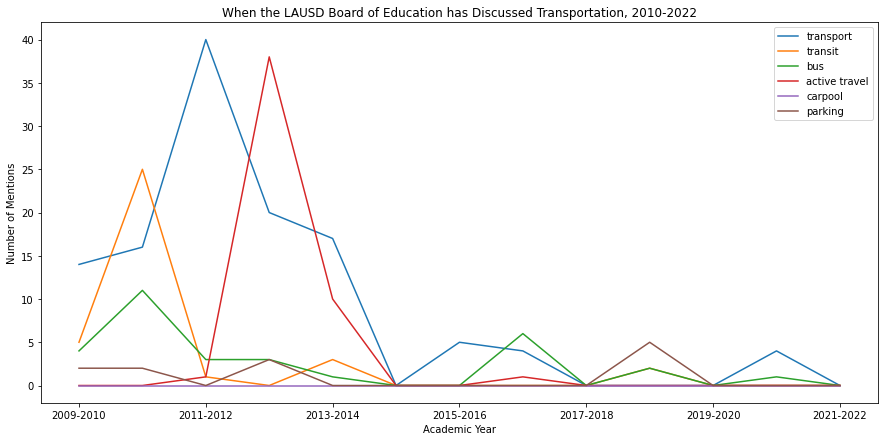

In [30]:
import matplotlib as plt


df_grouped[['transport','transit', 'bus', 'active travel', 'carpool', 'parking']].plot(
    figsize=(15,7),
    title='When the LAUSD Board of Education has Discussed Transportation, 2010-2022',
    xlabel='Academic Year', 
    ylabel='Number of Mentions',
    )



### About the above table and chart:

There are four notable spikes in discussion of transportation among the LAUSD board based only on the numbers:
1.	In 2010-2011, where the discussion seems to center on transit based on the numbers but also on buses (which can include school buses)
2.	In 2012-2013, there is substantial mention of transportation generally and of walking, biking, and Safe Routes to School;  that discussion seems to spill over into 2013-2014
3.	In 2016-2017, there was more discussion of transportation than the preceding year but not much – most of it was about buses.
4.	In 2018-2019, we see a little bit of discussion but mostly about parking.


.

.




## Analyzing the Concordances of Transportation Discussions

When the LAUSD Board discusses transportation, what are they talking about?  Here we use the NLTK library again to identify the concordance of the 100+ characters on either side of the transportation-related word appearing in the minutes for five specific analyses: 
1.  "transportation" across the entire time period

2.  transit during discussion peaks in 2010-2011 and 2018-2019

3.  active travel during a discussion peak in 2012-2014
4.  any use of bus during any time in the analysis
5.  the discussion of parking in 2018-2019

Following the code, we discuss that application these findings to the above temporal analysis and we draw conclusions about the relevancy for each highlighted subtopic or mode.

.
### Transportation Generally for All Years, 2009-2022

In [237]:
#Creating text objects for concordance analysis
text0910 = nltk.Text(df_grouped.wordsbyyear.loc['2009-2010'])
text1011 = nltk.Text(df_grouped.wordsbyyear.loc['2010-2011'])
text1112 = nltk.Text(df_grouped.wordsbyyear.loc['2011-2012'])
text1213 = nltk.Text(df_grouped.wordsbyyear.loc['2012-2013'])
text1314 = nltk.Text(df_grouped.wordsbyyear.loc['2013-2014'])
text1415 = nltk.Text(df_grouped.wordsbyyear.loc['2014-2015'])
text1516 = nltk.Text(df_grouped.wordsbyyear.loc['2015-2016'])
text1617 = nltk.Text(df_grouped.wordsbyyear.loc['2016-2017'])
text1718 = nltk.Text(df_grouped.wordsbyyear.loc['2017-2018'])
text1819 = nltk.Text(df_grouped.wordsbyyear.loc['2018-2019'])
text1920 = nltk.Text(df_grouped.wordsbyyear.loc['2019-2020'])
text2021 = nltk.Text(df_grouped.wordsbyyear.loc['2020-2021'])
text2122 = nltk.Text(df_grouped.wordsbyyear.loc['2021-2022'])

In [238]:
#Concordance for transportation
print("2009-2010")
text0910.concordance(['transportation'], width=114, lines=40)
print("2010-2011")
text1011.concordance(['transportation'], width=114, lines=40)
print("2011-2012")
text1112.concordance(['transportation'], width=114, lines=40)
print("2012-2013")
text1213.concordance(['transportation'], width=114, lines=40)
print("2013-2014")
text1314.concordance(['transportation'], width=114, lines=40)
print("2014-2015")
text1415.concordance(['transportation'], width=114, lines=40)
print("2015-2016")
text1516.concordance(['transportation'], width=114, lines=40)
print("2016-2017")
text1617.concordance(['transportation'], width=114, lines=40)
print("2017-2018")
text1718.concordance(['transportation'], width=114, lines=40)
print("2018-2019")
text1819.concordance(['transportation'], width=114, lines=40)
print("2019-2020")
text1920.concordance(['transportation'], width=114, lines=40)
print("2020-2021")
text2021.concordance(['transportation'], width=114, lines=40)
print("2021-2022")
text2122.concordance(['transportation'], width=114, lines=40)

2009-2010
Displaying 12 of 12 matches:
te seconded the motion mr enrique boullt director transportation branch shahryar khazei interim chief information 
 to questions from board members regarding public transportation discounts internet filtering software options use
ld dr morris and mr donald wilkes deputy director transportation branch responded to question from board members r
s as well whereas the united states department of transportation has banned all commercial truck and bus drivers f
s as well whereas the united states department of transportation has banned all commercial truck and bus drivers f
 silka iglesias city of los angeles department of transportation closed session items mr jefferson crain executive
lative affairs governmental relations director of transportation executive director adult career education executi
authority and the los angeles county metropolitan transportation authority resolving the districts challenge to th
t agreement with mr enrique boullt as dir

In [287]:
print(df_grouped.text.apply(lambda x: x.count('hometoschool')))
print(df_grouped.text.apply(lambda x: x.count('lcff') + x.count('local control funding formula')))

acad_year
2009-2010     0
2010-2011     0
2011-2012    12
2012-2013     4
2013-2014     0
2014-2015     0
2015-2016     0
2016-2017     0
2017-2018     0
2018-2019     0
2019-2020     0
2020-2021     0
2021-2022     0
Name: text, dtype: int64
acad_year
2009-2010     0
2010-2011     0
2011-2012     0
2012-2013    32
2013-2014     7
2014-2015     0
2015-2016     1
2016-2017     0
2017-2018     0
2018-2019     2
2019-2020     0
2020-2021     1
2021-2022     0
Name: text, dtype: int64


###  Transit at Discussion Peaks in 2010-2011 and 2018-2019

In [289]:
#Concordance for transit in 2010-2011 and 2018-2019

print("2010-2011")
text1011.concordance(['metropolitan', 'transportation'], width=114)
text1011.concordance(['metro'], width=114)
text1011.concordance(['transit'], width=114)
text1011.concordance(['ladot'], width=114)
text1011.concordance(['dash'], width=114)
text1011.concordance(['fareless'], width=114)
text1011.concordance(['tap', 'card'], width=114)

print("2018-2019")
text1819.concordance(['metropolitan,' 'transportation'], width=114)
text1819.concordance(['metro'], width=114)
text1819.concordance(['transit'], width=114)
text1819.concordance(['ladot'], width=114)
text1819.concordance(['dash'], width=114)
text1819.concordance(['fareless'], width=114)
text1819.concordance(['tap', 'card'], width=114)

2010-2011
Displaying 3 of 3 matches:
nimously adopted by the los angeles county metropolitan transportation authoritys la metro board of directors as 
nimously adopted by the los angeles county metropolitan transportation authoritys la metro board of directors as 
ut consideration to the los angeles county metropolitan transportation authority a portion of foshay learning cen
Displaying 3 of 3 matches:
eles county metropolitan transportation authoritys la metro board of directors as part of its long range transpor
eles county metropolitan transportation authoritys la metro board of directors as part of its long range transpor
ormance from june to september for los angeles county metro transit authority purchase orders the superintendent 
Displaying 19 of 19 matches:
le transportation system with a robust modern public transit system whereas in november los angeles county voters
 years whereas nearly of measure r funds will go for transit projects and programs including transit projects

In [291]:
#for some specifics
text1011.concordance(['transit'], width=450)

Displaying 19 of 19 matches:
tion that inhibits our economy whereas our nation and our county need the thousands of jobs and the environmental benefits that come from the development of a sustainable transportation system with a robust modern public transit system whereas in november los angeles county voters spoke with a clear voice about their priorities when they approved measure r a cent sales tax that will raise nearly billion for local transportation over years wherea
county voters spoke with a clear voice about their priorities when they approved measure r a cent sales tax that will raise nearly billion for local transportation over years whereas nearly of measure r funds will go for transit projects and programs including transit projects such as the wilshire subway and multiple light rail and bus rapid transit projects whereas measure r also includes for transit operating costs whereas students staff and t
bout their priorities when they approved measure r a cent sales tax tha

### Active Travel Modes in 2012-2014

In [226]:
#Concordance for walk/bike in 2012-2014

text1 = nltk.Text(df_grouped.wordsbyyear.loc['2012-2013'] + df_grouped.wordsbyyear.loc['2013-2014'])
text1.concordance(['walk'], width=114)
text1.concordance(['bike'], width=114)
text1.concordance(['bicycle'], width=114)
text1.concordance(['biking'], width=114)

Displaying 24 of 24 matches:
s in force ms martinez resolution declaring october as walk to school month for action october at pm whereas the l
hools from around the world to celebrate international walk to school month and millions of people participate in 
ntries as part of the annual initiative whereas during walk to school month network participating schools host eve
s to be physically active by walking to school whereas walk to school month emphasizes the importance of teaching 
ely cross streets and select a route to school whereas walk to school month highlights how easy and enjoyable walk
he health benefits of being active whereas engaging in walk to school activities creates a sense of community and 
 provide funding to improve safety of children as they walk or bike to school whereas school districts are respons
lly resolved that the board hereby declares october as walk to school month and directs the superintendent to enco
erintendent to encourage all district staff to prom

###  School Bus Mentions, Any Time

California school bus policy differs dramatically from other states, so we highlight here the discussions the LAUSD board has about this important travel mode.

In [297]:
#School Bus Any Time
print("2009-2010")
text0910.concordance(['bus'], width=114, lines=40)
print("2010-2011")
text1011.concordance(['bus'], width=114, lines=40)
print("2011-2012")
text1112.concordance(['bus'], width=114, lines=40)
print("2012-2013")
text1213.concordance(['bus'], width=114, lines=40)
print("2013-2014")
text1314.concordance(['bus'], width=3600, lines=40)
print("2014-2015")
text1415.concordance(['bus'], width=114, lines=40)
print("2015-2016")
text1516.concordance(['bus'], width=114, lines=40)
print("2016-2017")
text1617.concordance(['bus'], width=114, lines=40)
print("2017-2018")
text1718.concordance(['bus'], width=114, lines=40)
print("2018-2019")
text1819.concordance(['bus'], width=114, lines=40)
print("2019-2020")
text1920.concordance(['bus'], width=114, lines=40)
print("2020-2021")
text2021.concordance(['bus'], width=450, lines=40)
print("2021-2022")
text2122.concordance(['bus'], width=114, lines=40)

2009-2010
Displaying 2 of 2 matches:
 of transportation has banned all commercial truck and bus drivers from sending electronic text messages while dr
 of transportation has banned all commercial truck and bus drivers from sending electronic text messages while dr
2010-2011
Displaying 8 of 8 matches:
uch as the wilshire subway and multiple light rail and bus rapid transit projects whereas measure r also includes
sed the board on the resolution ms barbara lottholland bus riders union mr matthew kogan united teachers los ange
uch as the wilshire subway and multiple light rail and bus rapid transit projects whereas measure r also includes
tion audits consultant contracts weight room equipment bus demolition and employee training after discussion and 
rom board members regarding leaders of leaders program bus contract renewals and participation in ewaste program 
ed that goal making students parents cafeteria workers bus drivers teachers administrators and all other members 
ed that goal m

In [292]:
text1617.concordance(['bus'], width=450)

Displaying 6 of 6 matches:
approved the conditional enrollment of the students in case numbers a and a the vote was ayes the board of education authorized the initiation of the dismissal action of elementary school teachers high school teacher heavy bus driver and police officer the vote was ayes the board of education authorized initiating dismissal action of middle school teacher the vote was ayes bd of ed special board meeting cs minutes am the board of education autho
nrollment of the student in case number a with the recommended disposition the vote was ayes the board of education authorized the initiation of the dismissal action of high school teacher special education assistants area bus supervisor and bus dispatcher the vote was ayes bd of ed special board meeting cs minutes am the board of education authorized settlement in the case of jagielskibazzell et al v los angeles unified school district et al un
udent in case number a with the recommended disposition the vote was ayes

###  Parking in 2018-2019
While most LAUSD students cannot drive to school, nearly all of its staff is eligible to drive.  How does the LAUSD Board consider this?  They appear to discuss it with unusual frequency in 2018-2019.

In [285]:
#Concordance for parking in 2018-2019

text1819.concordance(['parking'], width=222)

Displaying 5 of 5 matches:
d from dr vladovic regarding the contract with los angeles county bicycle coalition and the contract for a parking lot attendant remarks were heard from mr melvoin and dr vladovic regarding the revenue contract for the me
 the assessors property tax data did not uniformly capture the square footage of all improvements used for parking whereas on february a public meeting of the board sitting as a committee of the whole was held at which di
public and media have recently raised questions about whether measure ee if it passes will levy the tax on parking structures and similar structures which the board hereby addresses now therefore be it resolved that the b
re and shall not be implemented to require collection of the per square foot levy on improvements used for parking whether residential or non residential resolved further that the text filed with the los angeles county re
ursuant to section iv paragraph a of the measure shall exclude the square footage of 

## Discussion of Transportation Discussion Peaks and Discussion Text

We previously identified four spikes in discussion about transportation.  After reading the relevant concordances, here is what we find:

1.	In 2010-2011 (and extending into 2011-2012), the discussion is chiefly concerns Governor Jerry Brown’s proposal to eliminate the state’s Home-to-School Transportation fund in 2010-11 and 2011-12.  There is addition mention of two LA County milestones that occurred in the year prior: the beginning of Measure R, which is a half-cent local option sales tax for Los Angeles County (which Measure M made permanent and increased in 2016), and the passage of the 2009 Long Range Transportation Plan.  Much of the discussion about transit during this period centered on new projects that Measure R would make possible, including the Purple Line Extension.  There was one mention of benefits for LAUSD families:
“…students staff and their families would greatly benefit from a safe modern and effective mass transit system especially when exercising their options for school choice.”


2.	In 2012-14, there are a few interacting transportation activities the board is discussing:
a.	They appointed Donald Wilkes as director of student transportation
b.	There is concern over the region’s Short Range Transportation Plan and its inadequacy in addressing active travel modes
c.	While the above is important and an external impetus for discussion, most of the mention of active travel during this time period was because board member Martinez declared October 2012 as “Walk to School Month” – however, the board did not ever mention the outcomes of this initative.
d.	A board member specifically mentions that students in the Bay Area “enjoy entirely free transportation on Bay Area Rapid Transit” (BART) whereas Los Angeles students do not
e.	They have continued discussing the money from Measure R


3.	In 2016-2017, the uptick in bus discussion centers on dismissal actions that included a bus driver; this occurred in other years, albeit less frequently.  There was no substantive discussion of actual bus transportation.  


4.	The discussion of parking is centered on ballot [Measure EE](/https://ballotpedia.org/Los_Angeles_Unified_School_District,_California,_Measure_EE,_Parcel_Tax_(June_2019)), a “school parcel tax measure” on the ballot in Los Angeles County for June 4, 2019.  The ballot measure, which failed by a margin of 8%, would have levied a $0.16 per square foot tax on building improvements annually for funding to LAUSD and local schools.  The LAUSD board in these minutes is discussing a provision in Section IV, Paragraph A of the measure that excludes the square footage of improvements used for parking in both residential and nonresidential buildings.  There was only one mention here of parking for users, which involved a parking lot attendant at the request of the Los Angeles County Bicycle Coalition.


## Conclusions for Subtopics and Modes

**Transportation generally:**  This appears to almost always be about funding.  There is more discussion again in 2012-13 and 2013-14 that appears to center on the state’s new Local Control Funding Formula, which left transportation outside of its new calculations.  

**Transit:**  Curiously, this rarely talks about student users; indeed, there is no mention of the new fareless transit program for students implemented in 2021.  This suggests that it perhaps is not LAUSD that wishes for this program to exist but that Metro wishes for it to exist, further suggesting that perhaps the program is more about ridership for Metro than it is improving access to education for LAUSD.  The principal spike in discussion about transit in 2010-2011 centered on two items: the beginning of funds received for [Measure R](/https://www.metro.net/about/measure-r/), which began in earnest in the last quarter of 2009, and the passage of Metro’s [2009 Long Range Transportation Plan](/https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjP_O_wxp74AhVroI4IHTVkBBcQFnoECAoQAQ&url=https%3A%2F%2Fnrm.dfg.ca.gov%2FFileHandler.ashx%3FDocumentID%3D21513&usg=AOvVaw14ALoP8blikd2ssGqcoxE_).

**Bus:**  While LAUSD receives roughly $77 million from the state each year to run transportation for its students, its board nearly never discusses school bus transportation.  It mentions the word “bus” in minutes only 31 times in 13 years.  The most common topic they discuss is labor, either driver termination or contract negotiation.  The board also discusses buses as part of countywide transit programs, but only once – in 2013-2014 – did board meeting minutes mention the provision of services to children, which was in the same comment comparing LAUSD to the Bay Area above:  
> “mr kayser urging los angeles county metropolitan authority to invest more in active transportation planning and funding res whereas the los angeles county metropolitan authority metro is currently working on a draft short range transportation plan srtp that will guide billion dollars of transportation investments in los angeles county over the next ten years whereas the modes of transportation used by pedestrians scooters skateboarders rollerbladers runners and cyclists fall into a category referred to as active transportation whereas almost one hundred percent of the los angeles unified school districts lausd students make daily use of active transportation as a means of getting around their communities and to and from school whereas due to drastic budget cuts the los angeles unified school district closed bus routes and eliminated services to many children while impoverished students in the san francisco unified school district continue to enjoy entirely free transportation on bay area rapid transit whereas a students level of mobility affects the academic athletic and artistic choices available within lausd be they pilot schools magnet schools transfers schools in zones of choice options schools adult education programs occupational centers etc whereas the student integration office magnet schools was forced by budget cuts to eliminate free transportation for students in elementary schools under two miles and under five miles for middle and high school students whereas the los angeles unified school district actively encourages bicycle use by students and employees and recently celebrated biketoschool day on may th whereas currently the short range transportation plan srtp does not provide a clear active transportation finance strategy and based on analysis of spending levels in other regions and current cost estimates for active transportation projects agencies in los angeles county will need to spend approximately million dollars per year to implement their plans for bicycle pedestrian safe routes to school and firstlast mile connections to transit over the next fortyfive years whereas the srtp proposes to spend a mere million of the entire tenyear billion plan on active transportation or approximately percent whereas nineteen percent of all trips in los angeles county use active transportation modes though only percent of the budget is dedicated to proving services to support active transportation…”

It is especially telling here that only when there is an opportunity to ask more of Metro does the LAUSD Board bring up its bus services.

**Safe Routes to School, Walking, and Biking:**  We aggregate the analyses of these because they largely fall into the criticism that board member Kayser levied against Metro for its [Short Range Transportation Plan](/https://media.metro.net/projects_studies/srtp/report_srtp_2014.pdf) in 2013-2014.  “Safe Routes” gets direct mention in 2011-2014, but not beyond that, and again this was largely tied to the Walk to School month.  The board does establish generally, however, that there is a lack of safe routes for children to walk or bike to school.

**Carpooling:**  Despite families colloquially referring to the traffic congestion outside schools as “the carpool line,” the LAUSD does not use the term carpool once in 13 years.  This is despite the private vehicle being the overwhelming principal mode of travel to and from school in California and despite the hope that fewer cars in the “carpool line” would be better for everyone.  This seems like a glaring oversight and suggests the LAUSD board is not aware – or not discussion – how children actually travel to school.

**Parking:**  Similarly to transit, it seems parking is a discussion point when there’s potential for money.  In fairness to the board here, though, Measure EE was an LAUSD proposal that the board ***should*** be discussing, including its minutiae.



.

.

.

### What ***Does*** the LAUSD Board Discuss?

While we see a decrease in overall discussion about transportation, we then follow up to ask: What does the LAUSD Board discuss during its meetings?  To uncover this, we apply additional stop words and create word frequency distributions using the NLTK ngrams function to analyze occurences of individual words, paired words, and trios of words by year.  (We show the word trios here to consolidate.)  Then, we combine all words into a single corpus encompassing all meeting minutes over the 13-year period to determine top issues and how transportation issues fit into the broader scope of LAUSD Board discussions.

We conclude with a discussion of this analysis and offer recommendations for future research.

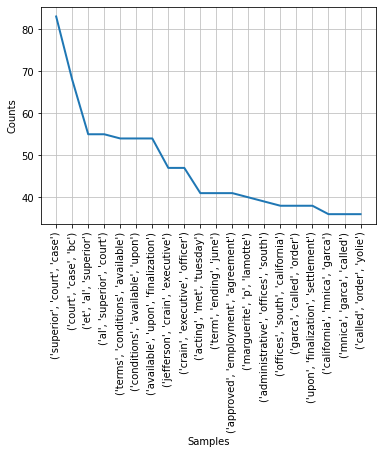

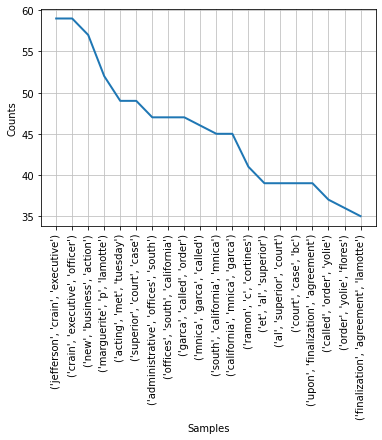

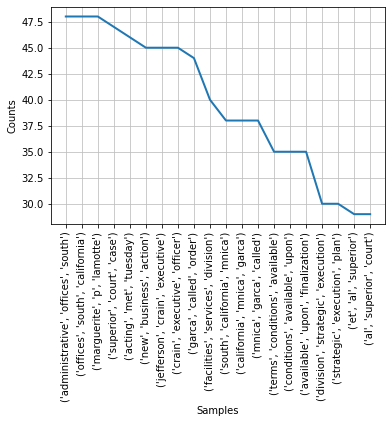

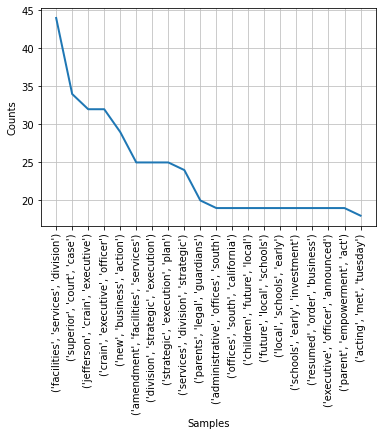

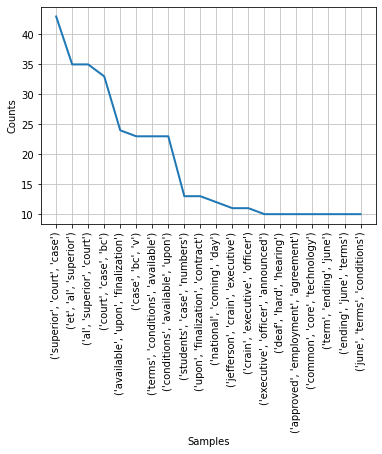

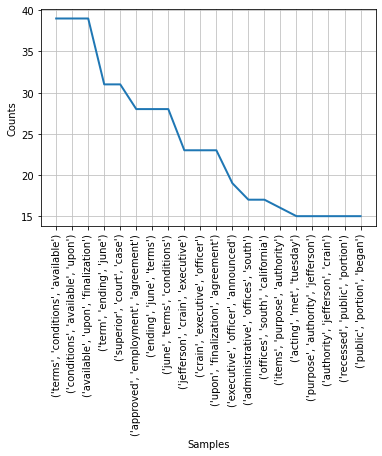

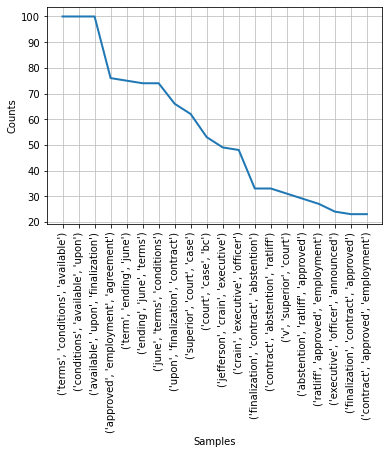

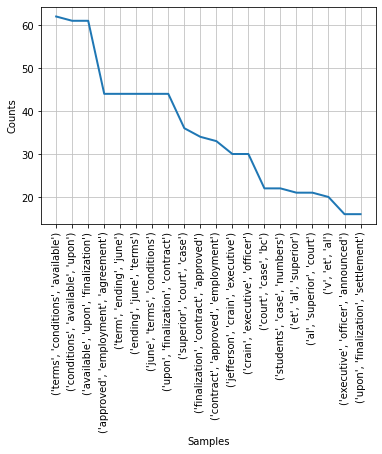

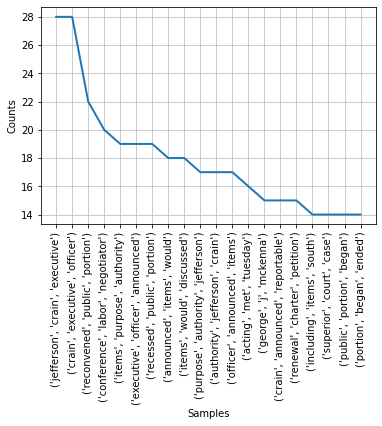

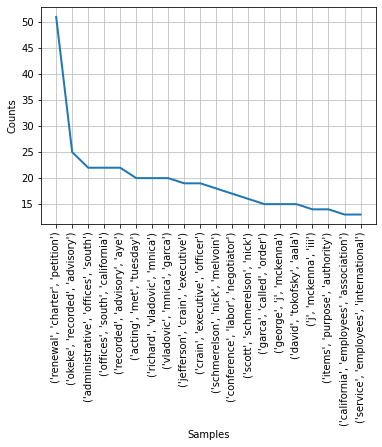

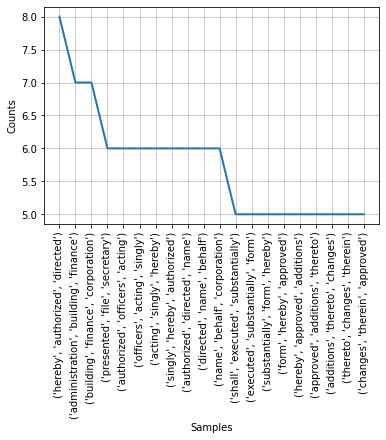

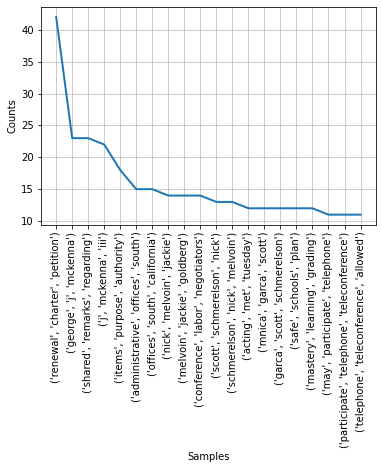

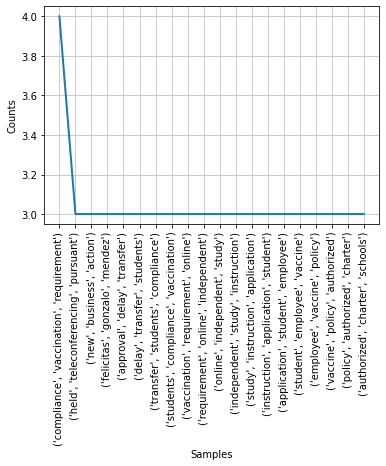

acad_year
2009-2010    AxesSubplot(0.125,0.125;0.775x0.755)
2010-2011    AxesSubplot(0.125,0.125;0.775x0.755)
2011-2012    AxesSubplot(0.125,0.125;0.775x0.755)
2012-2013    AxesSubplot(0.125,0.125;0.775x0.755)
2013-2014    AxesSubplot(0.125,0.125;0.775x0.755)
2014-2015    AxesSubplot(0.125,0.125;0.775x0.755)
2015-2016    AxesSubplot(0.125,0.125;0.775x0.755)
2016-2017    AxesSubplot(0.125,0.125;0.775x0.755)
2017-2018    AxesSubplot(0.125,0.125;0.775x0.755)
2018-2019    AxesSubplot(0.125,0.125;0.775x0.755)
2019-2020    AxesSubplot(0.125,0.125;0.775x0.755)
2020-2021    AxesSubplot(0.125,0.125;0.775x0.755)
2021-2022    AxesSubplot(0.125,0.125;0.775x0.755)
Name: wordsbyyear_clean, dtype: object

In [340]:
#ngrams
swords2 = swords + ['moved', 'adopted', 'general', 'consent', 'member', 'members', 'present', 'government', 
                    'code', 'question', 'questions', 'president', 'vote', 'ayes', 'discussion', 'motion',
                   'superintendent', 'following', 'whereas', 'dr', 'ed', 'bd', 'motion', 'seconded', 'report', 
                    '____________________________________']

df_grouped['wordsbyyear_clean'] = df_grouped.wordsbyyear.apply(lambda x: 
                                                               [word for word in x if word not in swords2])
df_grouped.wordsbyyear_clean.apply(lambda x: FreqDist(ngrams(x, 3)).plot(20))

In [341]:
def countWords(wordlist):
    counts = {} 
    
    for word in wordlist:
        lword = word.lower()
        if lword in counts:
            counts[lword] +=1
        else:
            counts[lword] = 1

    df_wc = pd.DataFrame.from_dict(counts, orient='index', columns=['word_count'])
    df_wc.sort_values('word_count', ascending=False, inplace=True)
    df_wc.index.name = 'word'
    
    return df_wc

wordlist = (df_grouped.wordsbyyear_clean.loc['2009-2010'] + df_grouped.wordsbyyear_clean.loc['2010-2011'] +
            df_grouped.wordsbyyear_clean.loc['2011-2012'] + df_grouped.wordsbyyear_clean.loc['2012-2013'] + 
            df_grouped.wordsbyyear_clean.loc['2013-2014'] + df_grouped.wordsbyyear_clean.loc['2014-2015'] + 
            df_grouped.wordsbyyear_clean.loc['2015-2016'] + df_grouped.wordsbyyear_clean.loc['2016-2017'] + 
            df_grouped.wordsbyyear_clean.loc['2017-2018'] + df_grouped.wordsbyyear_clean.loc['2018-2019'] + 
            df_grouped.wordsbyyear_clean.loc['2019-2020'] + df_grouped.wordsbyyear_clean.loc['2020-2021'] +
            df_grouped.wordsbyyear_clean.loc['2021-2022'])
df_wc = countWords(wordlist)
pd.options.display.max_rows = 400
df_wc['rank'] = df_wc['word_count'].rank(method='min', ascending=False)
print(df_wc[0:400])
print(df_wc.loc[['transportation', 'transport', 'transit', 'metro', 'metropolitan', 'bus', 'busing', 'buses', 'bused',
                'route', 'routes', 'walk', 'walking', 'bike', 'bicycle', 'biking', 'parking']])

                                    word_count   rank
word                                                 
charter                                   1985    1.0
students                                  1970    2.0
schools                                   1968    3.0
public                                    1529    4.0
garca                                     1510    5.0
california                                1337    6.0
vladovic                                  1139    7.0
zimmer                                    1076    8.0
student                                   1063    9.0
case                                      1029   10.0
resolved                                   999   11.0
approved                                   971   12.0
action                                     925   13.0
resolution                                 907   14.0
high                                       907   14.0
items                                      883   16.0
regarding                   

In [344]:
#df_wc.to_csv('/Volumes/GoogleDrive-105310167471895906199/My Drive/1 - Coursework/10 - 2021-22/UP 229/WhoPlansForSchoolTrips/word_count.csv')

##  Discussion of Overall Analysis and the Role of Transportation

Quite tellingly in the dawning age of school choice, the number-one most-frequently-used word in LAUSD meeting minutes is “charter.”  More predictably, “students,” “schools,” and “public” round out the top four before members of the board names begin to appear.  Some other notable words and rankings:

| Word    | Ranking |
| :---    | ---     |
| charter | 1st |
| teachers | 31st |
| learning	| 36th |
| employee | 44th |
| facilities | 50th
| funding | 64th |
| police | 93rd |
| arts | 98th |
| parents | 109th |
| families | 170th |
| discipline | 249th |
| transportation | 375th |

There are seven words tied with “transportation” at 375th, including “measure” (often Measure EE, M, or R), “promote,” and “strategy.”  None of the other transportation words break into the top 1000.


.

.

## Conclusion

Although evidence suggests that transportation plays an important role in improving student attendance ([Gottfried 2017](/https://doi.org/10.3102/0162373717699472), [Stein and Grigg 2019](/http://journals.sagepub.com/doi/10.3102/0002831219833917), [Pogodzinski et al. 2021](/https://doi.org/10.1177/00131245211027369)), the LAUSD board appears to mainly discuss transportation when there is some outside influence causing it to, whether that is a budget cut, a county transportation plan, or a labor need.  Their attitude based on these meeting minutes seems to ask what the state government or the county transportation agency can do for them, rather than the board asking how it can help its students get to and from school.

Future research should consider who else might be taking on this planning for students traveling to and from school.  If not LAUSD, who is taking responsibility, if anyone?  Potential candidates include the Los Angeles city Department of Transportation, the mayor's office, City Council, and LA Metro.  Future research could use a similar approach to ours here in analyzing meeting minutes for those bodies (or another equivalent form of public archive for the mayor).  Additionally, future research could compare LAUSD to other major urban school districts.  While the LAUSD Board may not discuss transportation frequently, do other major urban districts?  Further, how does the size of a district's school bus operation affect these discussions?  LAUSD offers comparatively few students yellow bus service to other major urban districts, which may result in their highest governing entity aschewing the topic for other pressing issues.

Ultimately, we encourage the LAUSD Board and other urban school district governing boards to consider transportation in their leadership.
